In [1]:
import os
import re
import pandas as pd
import numpy as np
import sys
import glob
import traceback
import json
import folium

sys.path.append('/lib')
import lib.helper as helper

%matplotlib inline
%load_ext folium_magic

CURRENT_DIR = os.getcwd()
DATA_DIR = CURRENT_DIR + '/data'
RAW_DATA_DIR = DATA_DIR + '/raw'
ANALYSES_DIR = "data/analyses/"
MAPS_DIR = DATA_DIR + "/maps"
UK_REGIONS_FILE = CURRENT_DIR + '/lib/UK-regions.json'

In [2]:
# Absolute or relative path to workshop data extracted from AMY
workshops_file = "data/raw/carpentry-workshops_GB_2020-01-30.csv"

In [3]:
workshops_df = pd.read_csv(workshops_file, encoding = "utf-8")

workshops_df.rename(columns={"venue": "institution"}, inplace=True)
# Add column 'description' which is used in popups in maps
workshops_df['popup'] = np.where(workshops_df["address"].empty, workshops_df["institution"],
                                               workshops_df["institution"] + ', ' + workshops_df["address"])

In [4]:
# Let's inspect our data
workshops_df.head(5)

,Unnamed: 0,Unnamed: 0.1,slug,amy_url,start,end,year,workshop_type,attendance,country,...,host,institution,address,latitude,longitude,tags,website_url,tasks,instructors,popup
0,0,0,2020-05-20-swansea,https://amy.carpentries.org/api/v1/events/2020...,2020-05-20,2020-05-21,2020,SWC,0,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,"Singleton Campus, Swansea University","Room 516, Vivian Tower, Swansea University, Si...",51.609054,-3.982323,['SWC'],https://sa2c.github.io/2020-05-20-swansea/,https://amy.carpentries.org/api/v1/events/2020...,[],"Singleton Campus, Swansea University, Room 516..."
1,1,1,2020-03-03-earlham,https://amy.carpentries.org/api/v1/events/2020...,2020-03-03,2020-03-04,2020,DC,0,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",52.621887,1.218976,['DC'],https://tgac.github.io/2020-03-03-earlham/,https://amy.carpentries.org/api/v1/events/2020...,[],"Earlham Institute, Norwich Research Park, Norw..."
2,2,2,2020-01-21-earlham,https://amy.carpentries.org/api/v1/events/2020...,2020-01-21,2020-01-22,2020,SWC,0,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,Earlham Institute,"Norwich Research Park, Norwich, NR4 7UZ UK",52.621887,1.218976,['SWC'],https://tgac.github.io/2020-01-21-earlham/,https://amy.carpentries.org/api/v1/events/2020...,[],"Earlham Institute, Norwich Research Park, Norw..."
3,3,3,2020-01-15-ukaea-swcarpentry,https://amy.carpentries.org/api/v1/events/2020...,2020-01-15,2020-01-30,2020,SWC,0,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,UK Atomic Energy Authority,"LRDC, Culham Science Centre, Abingdon",51.657000,-1.230000,['SWC'],https://ukaea-rse-training.github.io/2020-01-1...,https://amy.carpentries.org/api/v1/events/2020...,"['Matti Juvonen', 'Chris MacMackin', 'Qingfeng...","UK Atomic Energy Authority, LRDC, Culham Scien..."
4,4,4,2020-01-09-kcl,https://amy.carpentries.org/api/v1/events/2020...,2020-01-09,2020-01-10,2020,SWC,0,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,King's College London,"King's College London, Strand Campus, Bush Hou...",51.513115,-0.115560,['SWC'],https://swc-kc-london-01-2020.github.io/SWC-KC...,https://amy.carpentries.org/api/v1/events/2020...,"['Luca Di Stasio', 'George Graham']","King's College London, King's College London, ..."


In [5]:
# Let's inspect our data
workshops_df.tail(5)

,Unnamed: 0,Unnamed: 0.1,slug,amy_url,start,end,year,workshop_type,attendance,country,...,host,institution,address,latitude,longitude,tags,website_url,tasks,instructors,popup
269,269,269,2012-10-22-newcastle,https://amy.carpentries.org/api/v1/events/2012...,2012-10-22,2012-10-23,2012,SWC,31,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,Newcastle University,NaN,54.980095,-1.614614,['SWC'],https://swcarpentry.github.io/2012-10-22-newca...,https://amy.carpentries.org/api/v1/events/2012...,"['Mike Jackson', 'Steve McGough']",NaN
270,270,270,2012-09-13-dafx,https://amy.carpentries.org/api/v1/events/2012...,2012-09-13,2012-09-14,2012,SWC,33,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,University of York,University of York,53.948193,-1.052914,['SWC'],https://swcarpentry.github.io/2012-09-13-dafx/,https://amy.carpentries.org/api/v1/events/2012...,"['Chris Cannam', 'Luis Figueira', 'Adam Stark'...","University of York, University of York"
271,271,271,2012-07-10-ral,https://amy.carpentries.org/api/v1/events/2012...,2012-07-10,2012-07-12,2012,SWC,24,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,Rutherford Appleton Laboratory,,51.573333,-1.314722,['SWC'],,https://amy.carpentries.org/api/v1/events/2012...,"['Stefano Cozzini', 'Tommy Guy']","Rutherford Appleton Laboratory,"
272,272,272,2012-05-14-newcastle,https://amy.carpentries.org/api/v1/events/2012...,2012-05-14,2012-05-15,2012,SWC,41,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,Newcastle University,,54.980095,-1.614614,['SWC'],https://swcarpentry.github.io/2012-05-14-newca...,https://amy.carpentries.org/api/v1/events/2012...,"['Chris Cannam', 'Neil Philippe Chue Hong', 'S...","Newcastle University,"
273,273,273,2012-04-30-ucl,https://amy.carpentries.org/api/v1/events/2012...,2012-04-30,2012-05-01,2012,SWC,44,United Kingdom,...,https://amy.carpentries.org/api/v1/organizatio...,University College London,,51.559882,-0.133458,['SWC'],https://swcarpentry.github.io/2012-04-30-ucl/,https://amy.carpentries.org/api/v1/events/2012...,"['Chris Cannam', 'Greg Wilson']","University College London,"


      number_of_workshops
year                     
2012                    7
2013                   14
2014                   21
2015                   31
2016                   39
2017                   49
2018                   52
2019                   55
2020                    6


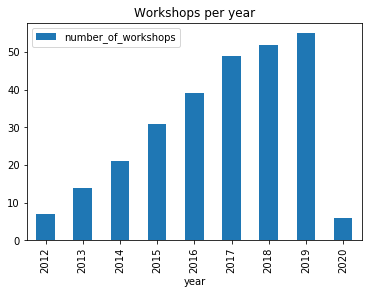

In [6]:
# How many workshops are there for each year?
workshops_per_year = workshops_df['year'].value_counts()
workshops_per_year.sort_index(ascending = True, inplace=True)
workshops_per_year.index.name = 'year'
workshops_per_year = workshops_per_year.to_frame('number_of_workshops')
print(workshops_per_year)
workshops_per_year.plot(kind='bar', legend=True, title ="Workshops per year")

workshop_type  DC  LC  SWC  TTT
year                           
2012            0   0    7    0
2013            0   0   14    0
2014            0   0   21    0
2015            2   1   25    3
2016            7   0   29    3
2017           12   2   31    4
2018            9   2   40    1
2019           14   0   38    3
2020            1   0    5    0


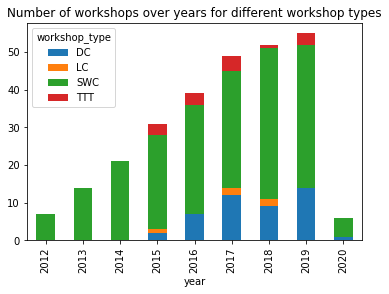

In [7]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

               number_of_workshops
workshop_type                     
SWC                            210
DC                              45
TTT                             14
LC                               5


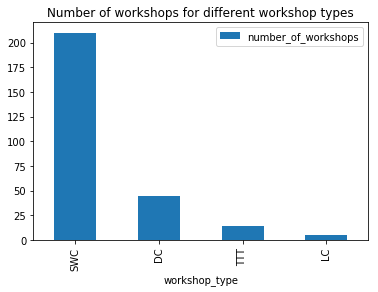

In [8]:
# How many SWC, DC, LC, TTT workshops were held so far?
workshops_per_type = workshops_df['workshop_type'].value_counts()
workshops_per_type.index.name = 'workshop_type'
workshops_per_type = workshops_per_type.to_frame('number_of_workshops')
print(workshops_per_type)
workshops_per_type.plot(kind='bar', legend=True, title ="Number of workshops for different workshop types")

workshop_type  DC  LC  SWC  TTT
year                           
2012            0   0    7    0
2013            0   0   14    0
2014            0   0   21    0
2015            2   1   25    3
2016            7   0   29    3
2017           12   2   31    4
2018            9   2   40    1
2019           14   0   38    3
2020            1   0    5    0


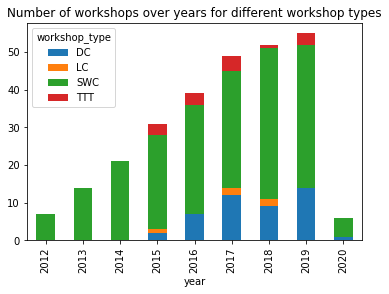

In [9]:
# How are numbers of different workshops (SWC, DC, LC, TTT) changing over years?
workshops_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['workshop_type'].count().unstack('workshop_type').fillna(0).astype(dtype='int')
workshops_per_type_per_year.plot(kind='bar', stacked=True, title="Number of workshops over years for different workshop types")
print(workshops_per_type_per_year)

In [10]:
print(workshops_per_type_per_year.columns)

Index(['DC', 'LC', 'SWC', 'TTT'], dtype='object', name='workshop_type')


ed.ac.uk                  31
ucl.ac.uk                 30
manchester.ac.uk          29
imperial.ac.uk            22
ox.ac.uk                  18
leeds.ac.uk               16
southampton.ac.uk         12
cam.ac.uk                 11
st-andrews.ac.uk          10
bham.ac.uk                10
earlham.ac.uk              8
swansea.ac.uk              7
kcl.ac.uk                  7
bristol.ac.uk              4
shef.ac.uk                 3
software-carpentry.org     3
dundee.ac.uk               3
qmul.ac.uk                 3
tgac.ac.uk                 3
aber.ac.uk                 3
nhm.ac.uk                  2
qub.ac.uk                  2
york.ac.uk                 2
gla.ac.uk                  2
nottingham.ac.uk           2
ncl.ac.uk                  2
exeter.ac.uk               2
rhul.ac.uk                 2
crick.ac.uk                2
city.ac.uk                 1
liv.ac.uk                  1
le.ac.uk                   1
greenwich.gov.uk           1
bradford.ac.uk             1
port.ac.uk    

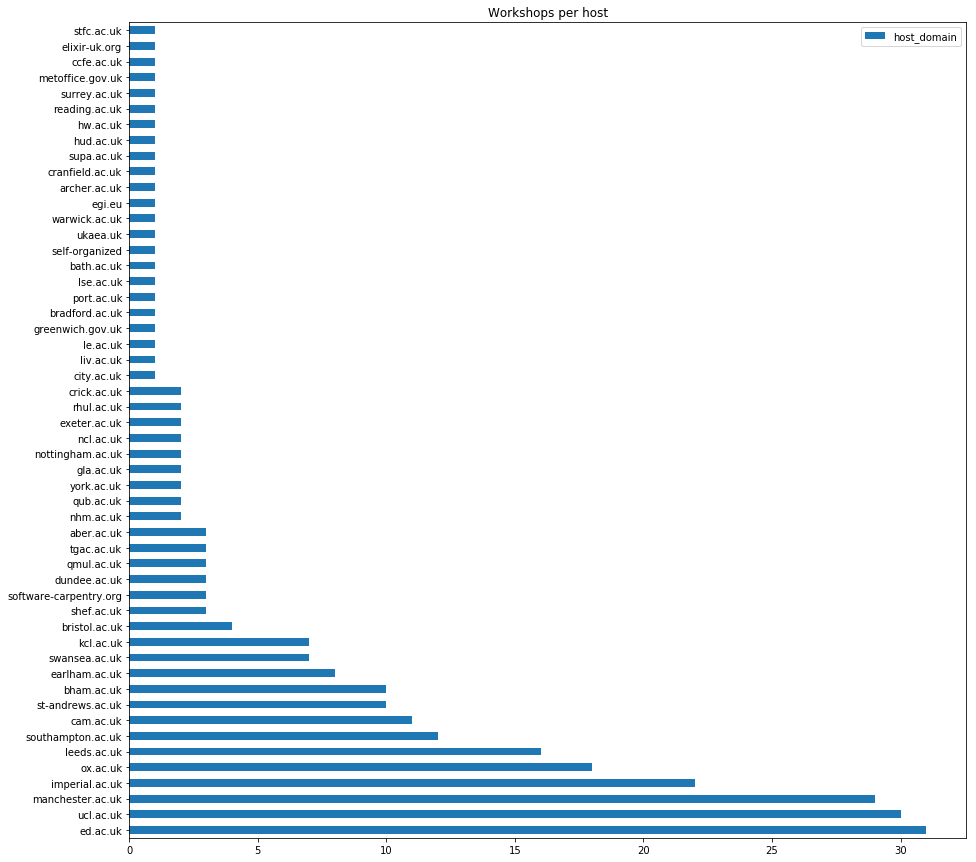

In [11]:
# How many workshops were held at each host institution?
workshops_per_host = workshops_df['host_domain'].value_counts()
print(workshops_per_host)
workshops_per_host.plot(kind='barh', legend=True, title ="Workshops per host", figsize = (15,15))

In [12]:
# How many workshops have been held at each instituion each year?
# Remove rows with NaN value for the institution
workshops_df = workshops_df.dropna(subset=['host_domain'])

workshops_per_host_per_year = pd.core.frame.DataFrame(
    {'number_of_workshops': workshops_df.groupby(['host_domain', 'year']).size()}).reset_index()
workshops_per_host_per_year_pivot = workshops_per_host_per_year.pivot_table(index='host_domain', columns='year')
workshops_per_host_per_year_pivot = workshops_per_host_per_year_pivot.fillna(0).astype('int')
workshops_per_host_per_year_pivot

number_of_workshops                                     \
year                                  2012 2013 2014 2015 2016 2017 2018 2019   
host_domain                                                                     
aber.ac.uk                               0    0    0    0    0    0    3    0   
archer.ac.uk                             0    0    0    0    0    0    0    1   
bath.ac.uk                               0    1    0    0    0    0    0    0   
bham.ac.uk                               0    0    0    0    0    0    3    7   
bradford.ac.uk                           0    0    0    0    0    0    0    1   
bristol.ac.uk                            0    1    0    0    1    2    0    0   
cam.ac.uk                                0    0    2    2    2    2    2    1   
ccfe.ac.uk                               0    0    0    1    0    0    0    0   
city.ac.uk                               0    0    0    1    0    0    0    0   
cranfield.ac.uk                          0    0    1    0    0    0    0    0   
crick.ac.uk                              0    0    0    0    0    2    0    0   
dundee.ac.uk                             0    1    0    0    1    1    0    0   
earlham.ac.uk                            0    0    0    0    1    3    0    2   
ed.ac.uk                                 1    1    1    2    6    2    8   10   
egi.eu                                   0    1    0    0    0    0    0    0   
elixir-uk.org                            0    0    0    0    0    0    0    1   
exeter.ac.uk                             0    1    0    0    0    1    0    0   
gla.ac.uk                                0    0    1    0    0    1    0    0   
greenwich.gov.uk                         0    1    0    0    0    0    0    0   
hud.ac.uk                                0    0    0    0    1    0    0    0   
hw.ac.uk                                 0    0    0    0    0    0    0    1   
imperial.ac.uk                           0    0    2    3    1    5    7    4   
kcl.ac.uk                                0    0    0    0    0    0    3    3   
le.ac.uk                                 0    0    0    0    0    0    1    0   
leeds.ac.uk                              0    0    1    4    7    3    1    0   
liv.ac.uk                                0    0    1    0    0    0    0    0   
lse.ac.uk                                0    0    0    0    0    0    1    0   
manchester.ac.uk                         0    1    3    5    2    5    7    6   
metoffice.gov.uk                         0    0    0    0    1    0    0    0   
ncl.ac.uk                                2    0    0    0    0    0    0    0   
nhm.ac.uk                                0    0    0    0    2    0    0    0   
nottingham.ac.uk                         0    0    1    0    1    0    0    0   
ox.ac.uk                                 1    1    0    3    2    5    4    2   
port.ac.uk                               0    0    0    1    0    0    0    0   
qmul.ac.uk                               0    1    0    0    0    1    0    1   
qub.ac.uk                                0    0    0    0    1    1    0    0   
reading.ac.uk                            0    0    1    0    0    0    0    0   
rhul.ac.uk                               0    0    0    1    1    0    0    0   
self-organized                           0    0    0    0    0    1    0    0   
shef.ac.uk                               0    0    0    0    0    3    0    0   
software-carpentry.org                   0    0    0    0    0    0    0    3   
southampton.ac.uk                        0    1    1    2    2    4    2    0   
st-andrews.ac.uk                         0    0    0    1    0    3    3    3   
stfc.ac.uk                               1    0    0    0    0    0    0    0   
supa.ac.uk                               0    1    0    0    0    0    0    0   
surrey.ac.uk                             0    0    0    1    0    0    0    0   
swansea.ac.uk                            0    0    0  

year
2012     228
2013     439
2014     509
2015     880
2016     818
2017    1072
2018     830
2019     642
2020       0
Name: attendance, dtype: int64


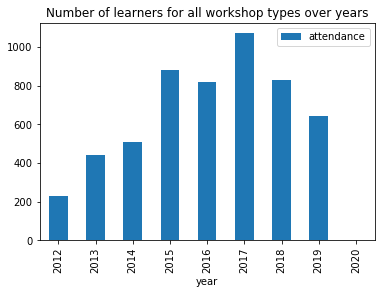

In [13]:
# How many learners attended workshops over years?
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().fillna(0).astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Number of learners for all workshop types over years")

Average workshop attendance: 20

year
2012     228
2013     439
2014     509
2015     880
2016     818
2017    1072
2018     830
2019     642
2020       0
Name: attendance, dtype: int64


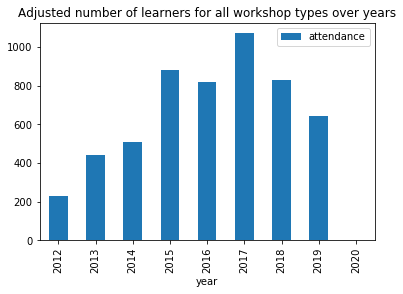

In [14]:
# How many learners attended workshops over years (with adjustments for missing attendance data with average attendance)?

# Disregard TTT workshops as they have attendance capped at 20 most of the times
average_attendance = round(workshops_df[workshops_df["workshop_type"] != "TTT"]["attendance"].mean())
print("Average workshop attendance: " + str(average_attendance) + "\n")
# Adjusted attendance over year data and graph
workshops_df["attendance"].fillna(average_attendance, inplace=True)
attendance_per_year = workshops_df.groupby(['year'])["attendance"].sum().astype("int")
print(attendance_per_year)
attendance_per_year.plot(kind='bar', legend=True, title ="Adjusted number of learners for all workshop types over years")

workshop_type
DC      808
LC      164
SWC    4194
TTT     252
Name: attendance, dtype: int64


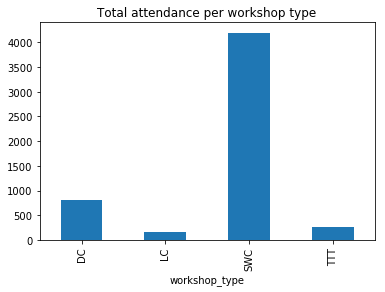

In [15]:
# Total attendance for different workshop types (with missing data adjusted with average attendance)
attendance_per_type = workshops_df.groupby(['workshop_type'])['attendance'].sum().astype("int")
print(attendance_per_type)
attendance_per_type.plot(kind="bar", title="Total attendance per workshop type")

workshop_type   DC  LC  SWC  TTT
year                            
2012             0   0  228    0
2013             0   0  439    0
2014             0   0  509    0
2015            78  59  686   57
2016           144   0  614   60
2017           284  51  652   85
2018           139  54  632    5
2019           163   0  434   45
2020             0   0    0    0


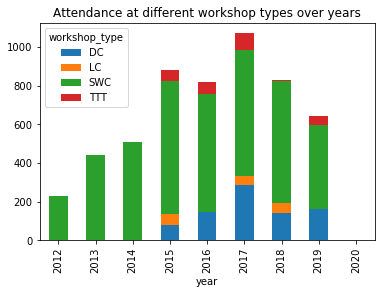

In [16]:
# How many learners attended each of (SWC, DC, LC, TTT) workshops over years (missing data adjusted by average attendance)?
attendance_per_type_per_year = workshops_df.groupby(['workshop_type', 'year'])['attendance'].sum().unstack("workshop_type").fillna(0).astype("int")
print(attendance_per_type_per_year)
attendance_per_type_per_year.plot(kind='bar', stacked=True, title="Attendance at different workshop types over years")


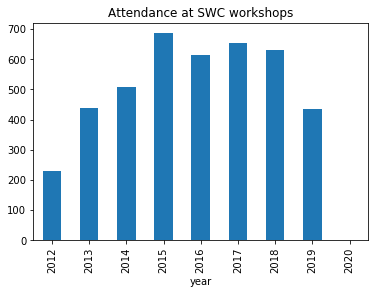

In [17]:
# Attendance just for SWC workshops over years
# Can be done similarly for DC, LC, TTT workshops, this is just an example
attendance_per_type_per_year["SWC"].plot(kind='bar', title="Attendance at SWC workshops")

In [18]:
# How are workshops spread over UK regions? (This may take a while to calculate)
workshops_df['region'] = workshops_df.apply(lambda x: helper.get_uk_region(latitude=x['latitude'],
                                    longitude=x['longitude']), axis=1)
print("###################################################")
print("Finished getting UK regions for workshop locations.")

Looking up region for geocoordinates: (51.609054, -3.9823230000000014)
Looking up region for geocoordinates: (52.621887, 1.218976)
Looking up region for geocoordinates: (52.621887, 1.218976)
Looking up region for geocoordinates: (51.657, -1.23)
Looking up region for geocoordinates: (51.513115, -0.11556)
Looking up region for geocoordinates: (51.61790300000001, -3.880897)
Looking up region for geocoordinates: (51.51159000000001, -0.11896)
Looking up region for geocoordinates: (53.466853, -2.2360777)
Looking up region for geocoordinates: (51.609054, -3.9823230000000014)
Looking up region for geocoordinates: (52.0746169, -0.6304773)
Looking up region for geocoordinates: (53.46400300000001, -2.230456)
Looking up region for geocoordinates: (51.4988, -0.174877)
Looking up region for geocoordinates: (55.921864, -3.17441)
Looking up region for geocoordinates: (51.52245, -0.13263)
Looking up region for geocoordinates: (51.49815200000001, -0.178368)
Looking up region for geocoordinates: (51.4919

                          number_of_workshops
region                                       
London                                     70
Scotland                                   47
South East                                 39
North West                                 31
Yorkshire and The Humber                   24
Eastern                                    23
West Midlands                              11
Wales                                      11
South West                                  8
East Midlands                               6
Northern Ireland                            2
North East                                  2


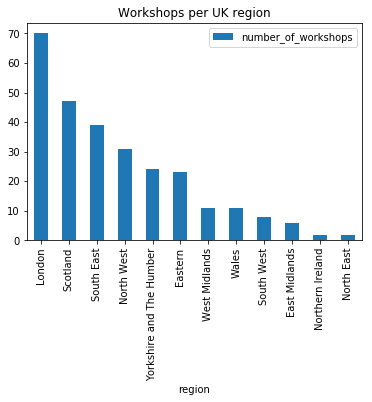

In [19]:
# How many workshops per UK regions?
workshops_per_UK_region = workshops_df['region'].value_counts()
workshops_per_UK_region.index.name = 'region'
workshops_per_UK_region = workshops_per_UK_region.to_frame('number_of_workshops')
print(workshops_per_UK_region)
workshops_per_UK_region.plot(kind='bar', legend=True, title ="Workshops per UK region")

In [20]:
# Let's do a choropleth map of workshops per UK regions
uk_regions = json.load(open(UK_REGIONS_FILE, encoding='utf-8-sig'))
workshops_map = helper.generate_choropleth_map(workshops_df, uk_regions, "workshops")
workshops_map

IndexError: list index out of range

In [21]:
# Let's draw a clustered map of all workshop locations
workshops_map = helper.generate_map_with_clustered_markers(workshops_df)
workshops_map

In [22]:
# Save all analyses into an Excel spreadsheet
if not os.path.exists(ANALYSES_DIR):
    os.makedirs(ANALYSES_DIR)

workshops_file_name = os.path.basename(workshops_file)
workshops_file_name_without_extension = re.sub('\.csv$', '', workshops_file_name.strip())
workshop_analyses_excel_file = ANALYSES_DIR + "analysed_" + workshops_file_name_without_extension + '_from_ipynb.xlsx'

excel_writer = pd.ExcelWriter(workshop_analyses_excel_file, engine='xlsxwriter')

workshops_df.to_excel(excel_writer, sheet_name="carpentry_workshops", index=False)

# Workshops per year
workshops_per_year.to_excel(excel_writer, sheet_name='workshops_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_year', 1, 0, len(workshops_per_year.index), 0],
        'values': ['workshops_per_year', 1, 1, len(workshops_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per year'})
worksheet.insert_chart('I2', chart)

# Workshops per type   
workshops_per_type.to_excel(excel_writer, sheet_name='workshops_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_type', 1, 0, len(workshops_per_type.index), 0],
        'values': ['workshops_per_type', 1, 1, len(workshops_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types'})
worksheet.insert_chart('I2', chart)
    
# Workshops per type per year
workshops_per_type_per_year.to_excel(excel_writer, sheet_name='workshops_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(workshops_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['workshops_per_type_per_year', 0, i],
            'categories': ['workshops_per_type_per_year', i, 0, len(workshops_per_type_per_year.index), 0],
            'values': ['workshops_per_type_per_year', 1, i, len(workshops_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops of different types over years'})
worksheet.insert_chart('B20', chart)

# Workshops per host
workshops_per_host.to_excel(excel_writer, sheet_name='workshops_per_host', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['workshops_per_host']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['workshops_per_host', 1, 0, len(workshops_per_host.index), 0],
        'values': ['workshops_per_host', 1, 1, len(workshops_per_host.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Host institution'})
chart.set_y_axis({'name': 'Number of workshops', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of workshops per host'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per year
attendance_per_year.to_excel(excel_writer, sheet_name='attendance_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_year']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_year', 1, 0, len(attendance_per_year.index), 0],
        'values': ['attendance_per_year', 1, 1, len(attendance_per_year.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per year (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type
attendance_per_type.to_excel(excel_writer, sheet_name='attendance_per_type', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type']
chart = workbook.add_chart({'type': 'column'})
chart.add_series({
        'categories': ['attendance_per_type', 1, 0, len(attendance_per_type.index), 0],
        'values': ['attendance_per_type', 1, 1, len(attendance_per_type.index), 1],
        'gap': 2,
    })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_legend({'position': 'none'})
chart.set_x_axis({'name': 'Workshop type'})
chart.set_y_axis({'name': 'Number of attendees', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Number of attendees per workshop type (with estimates for missing data)'})
worksheet.insert_chart('I2', chart)

# Workshop attendance per workshop type per year
attendance_per_type_per_year.to_excel(excel_writer, sheet_name='attendance_per_type_per_year', index=True)
workbook = excel_writer.book
worksheet = excel_writer.sheets['attendance_per_type_per_year']
chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
for i in range(1, len(attendance_per_type_per_year.columns) + 1):
    chart.add_series({
            'name': ['attendance_per_type_per_year', 0, i],
            'categories': ['attendance_per_type_per_year', i, 0, len(attendance_per_type_per_year.index), 0],
            'values': ['attendance_per_type_per_year', 1, i, len(attendance_per_type_per_year.index), i],
            'gap': 2,
        })
chart.set_y_axis({'major_gridlines': {'visible': False}})
chart.set_x_axis({'name': 'Year'})
chart.set_y_axis({'name': 'Attendance', 'major_gridlines': {'visible': False}})
chart.set_title({'name': 'Attendance at workshops of different types over years (with estimates for missing data)'})
worksheet.insert_chart('B20', chart)

excel_writer.save()
print("Saved workshop analyses in " + workshop_analyses_excel_file)

Saved workshop analyses in data/analyses/analysed_carpentry-workshops_GB_2020-01-30_from_ipynb.xlsx
